## LightGBM Modeling for Churn Prediction

This notebook trains a LightGBM model for customer churn prediction using the SHAP-selected features from Random Forest. It includes hyperparameter tuning, threshold optimization, and final model export.

## Import Required Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import joblib

## Load Final Dataset

In [11]:
# Load the encoded and feature-engineered dataset
clean_df = pd.read_csv("D:/Sajid/Chrun_Prediction/data/processed/final_encoded_data.csv")
print("Shape:", clean_df.shape)

Shape: (7032, 43)


## Split features and target

In [12]:
X = clean_df.drop(columns=["Churn"])
y = clean_df["Churn"]

In [13]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Load SHAP-Selected Features from Random Forest

- These features were saved after SHAP-based selection in the Random Forest modeling step. Using these ensures consistency across models.

In [14]:
selected_features = joblib.load("D:/Sajid/Chrun_Prediction/deployment/shap_selected_features.pkl")
print("Loaded Features:", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


Loaded Features: ['is_long_term_contract', 'tenure', 'InternetService_Fiber optic', 'MonthlyCharges', 'Contract_Two year', 'PaymentMethod_Electronic check', 'is_tech_dependent']


## Hyperparameter Tuning with GridSearchCV

In [15]:
# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42
    #scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])# Handle class imbalance
)
param_grid = {
    'num_leaves': [31,50],  # More leaves capture complex patterns
    'max_depth': [-1, 10, 15],  # -1 means no depth limit
    'learning_rate': [0.01, 0.05],  # Lower learning rates improve generalization
    'n_estimators': [50,100, 500],  # Number of boosting rounds
    'min_child_samples': [20,30,50],  # Minimum samples per leaf (avoid overfitting)
    'subsample': [0.6,0.8, 1.0],  # Prevents overfitting
    #'colsample_bytree': [0.8, 1.0],  # Feature sampling per tree
    'scale_pos_weight': [2,3,5],      # Balanced weights
    'reg_lambda': [0,2],               # L2 regularization
}

# Perform Grid Search on Training Data ONLY
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=3,  # Cross-validation within training data
    scoring='recall',
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search ONLY on Training Data
grid_search.fit(X_train_selected, y_train)

# Get Best Parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 50, 'num_leaves': 31, 'reg_lambda': 0, 'scale_pos_weight': 5, 'subsample': 0.6}


## Train Final Model Using Best Parameters

- We retrain LightGBM using the best hyperparameters found from grid search.

In [16]:
# Train the Final Model on FULL Training Data
final_lgb = lgb.LGBMClassifier(**best_params, random_state=42)
final_lgb.fit(
    X_train_selected , y_train,
    eval_set=[(X_train_selected , y_train)],  # Training set used for monitoring
    eval_metric="binary_logloss",
    callbacks=[
        lgb.early_stopping(50), ## stop if AUC does not improve
        lgb.log_evaluation(period=10)  # Logs every 10 rounds
    ]
)

Training until validation scores don't improve for 50 rounds
[10]	training's binary_logloss: 0.493995
[20]	training's binary_logloss: 0.489109
[30]	training's binary_logloss: 0.500733
[40]	training's binary_logloss: 0.512608
[50]	training's binary_logloss: 0.521139
Did not meet early stopping. Best iteration is:
[16]	training's binary_logloss: 0.487559


LGBMClassifier(learning_rate=0.05, min_child_samples=50, n_estimators=50,
               random_state=42, reg_lambda=0, scale_pos_weight=5,
               subsample=0.6)

## Evaluate on Test Set (with Optimal Threshold)

In [22]:
# Predictions on Test Data
#y_pred = final_lgb.predict(X_test[selected_features])
y_pred_proba = final_lgb.predict_proba(X_test_selected)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba) ### generate array of precison, recall and threshold
f1_scores = 2 * (precision * recall) / (precision + recall)


# Instead of using the default 0.5 threshold, we choose the one that maximizes the F1-score using the precision-recall curve.

best_threshold = thresholds[np.argmax(f1_scores)]  # to get threshold with best f1 score

y_pred = (y_pred_proba > best_threshold).astype(int)  # Adjust threshold here

# Evaluate Performance
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Final Test Set AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.7619047619047619
Final Test Set AUC: 0.8355589089459597
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



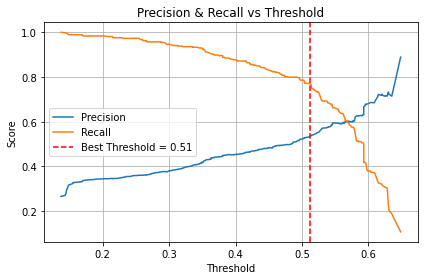

In [19]:
# Plot Precision-Recall vs Threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(best_threshold, color='red', linestyle="--", label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Save Final LightGBM Model

- Export the final LightGBM model as a `.pkl` file to be used for deployment (Flask API)

In [21]:
joblib.dump(final_lgb, "D:/Sajid/Chrun_Prediction/deployment/final_lightgbm_model.pkl")
print("Final LightGBM model saved as final_lightgbm_model.pkl")

Final LightGBM model saved as final_lightgbm_model.pkl
